In [1]:
# Imports
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from sklearn.metrics import classification_report
from collections import namedtuple

In [2]:
# Load data
train = np.loadtxt('kepler_dataset/exoTrain.csv', delimiter=",", skiprows=1, dtype=np.float32)
test = np.loadtxt('kepler_dataset/exoTest.csv', delimiter=",", skiprows=1, dtype=np.float32)

In [3]:
# Preprocess data

# Normalize all data
train[:,1:] = (train[:,1:] - np.mean(train[:,1:], axis=1).reshape(-1,1) / np.std(train[:,1:], axis=1).reshape(-1,1))
train[:,:1] = train[:,:1] - 1

test[:,1:] = (test[:,1:] - np.mean(test[:,1:], axis=1).reshape(-1,1) / np.std(test[:,1:], axis=1).reshape(-1,1))
test[:,:1] = test[:,:1] - 1

# Augment train data
idx_one = np.where(train[:,:1] == 1)[0]
idx_zero = np.where(train[:,:1] == 0)[0]

start_time = time.time()
new_rows = np.zeros([len(idx_zero) - len(idx_one), train.shape[1]], dtype='float32')
for i in range(len(idx_zero) - len(idx_one)):
    idx_source = np.random.randint(len(idx_one))
    time_shift = np.random.randint(train.shape[1] - 1)
    new_rows[i,:1] = train[idx_source][:1]
    new_rows[i,1:] = np.roll(train[idx_source][1:], time_shift)
train = np.vstack([train, new_rows])
print(time.time() - start_time)
    
# Shuffle train data
np.random.shuffle(train)

# Add dimension and moving avg
x_train = np.expand_dims(train[:, 1:], axis=2)
x_train = np.concatenate((x_train, uniform_filter1d(x_train, axis=1, size=200)), axis=2)
y_train = np.expand_dims(train[:, 0].astype(np.int32), axis=1)

x_test = np.expand_dims(test[:, 1:], axis=2)
x_test = np.concatenate((x_test, uniform_filter1d(x_test, axis=1, size=200)), axis=2)
y_test = np.expand_dims(test[:, 0].astype(np.int32), axis=1)

0.22763514518737793


In [137]:
# Create Dataset and Iterator
batch_size = 32
tf.reset_default_graph()

# Train dataset
x_train_placeholder = tf.placeholder(x_train.dtype, x_train.shape)
y_train_placeholder = tf.placeholder(y_train.dtype, y_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_placeholder, y_train_placeholder))
train_dataset = train_dataset.batch(batch_size)

# Test dataset
x_test_placeholder = tf.placeholder(x_test.dtype, x_test.shape)
y_test_placeholder = tf.placeholder(y_test.dtype, y_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_placeholder, y_test_placeholder))
test_dataset = test_dataset.batch(batch_size)

# Create iterator and its initializers
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
next_batch = iterator.get_next()
train_iter_op = {'fetches': iterator.make_initializer(train_dataset), 
                      'feed_dict': {x_train_placeholder: x_train, y_train_placeholder: y_train}}
test_iter_op = {'fetches': iterator.make_initializer(test_dataset), 
                     'feed_dict': {x_test_placeholder: x_test, y_test_placeholder: y_test}}

In [138]:
# Build graph
x_batch, y_batch = next_batch

conv1_w = tf.get_variable('conv_layer1_weights', shape=[49, 2, 16], initializer=tf.contrib.layers.xavier_initializer())
conv2_w = tf.get_variable('conv_layer2_weights', shape=[23, 16, 32], initializer=tf.contrib.layers.xavier_initializer())
conv3_w = tf.get_variable('conv_layer3_weights', shape=[11, 32, 64], initializer=tf.contrib.layers.xavier_initializer())
#conv4_w = tf.get_variable('conv_layer4_weights', shape=[11, 64, 128], initializer=tf.contrib.layers.xavier_initializer())

conv1_b = tf.get_variable('conv_layer1_bias', 16, initializer=tf.constant_initializer(0))
conv2_b = tf.get_variable('conv_layer2_bias', 32, initializer=tf.constant_initializer(0))
conv3_b = tf.get_variable('conv_layer3_bias', 64, initializer=tf.constant_initializer(0))
#conv4_b = tf.get_variable('conv_layer4_bias', 128, initializer=tf.constant_initializer(0))

#keep_prob = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(x_batch, conv1_w, 1, 'VALID'), conv1_b))
model_out = tf.layers.max_pooling1d(model_out, pool_size=4, strides=4, padding='VALID')

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(model_out, conv2_w, 1, 'VALID'), conv2_b))
model_out = tf.layers.max_pooling1d(model_out, pool_size=4, strides=4, padding='VALID')

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(model_out, conv3_w, 1, 'VALID'), conv3_b))
model_out = tf.layers.max_pooling1d(model_out, pool_size=4, strides=4, padding='VALID')

model_out = tf.nn.dropout(model_out, 0.65)

model_out = tf.contrib.layers.flatten(model_out)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.contrib.layers.fully_connected(model_out, 1, activation_fn=None)

loss = tf.losses.sigmoid_cross_entropy(y_batch, model_out)

training_op = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.sigmoid(model_out)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.to_int32(tf.greater(prediction, threshold)), y_batch)))

In [ ]:
Epoch_Data = namedtuple('Epoch_data', ['loss', 'acc', 'pred', 'time'])

def run_epoch(iter_init_op, train=False, lr=0.00001, thresh=0.5):
    
    fetch_list = [loss, prediction, accuracy, training_op] if train else [loss, prediction, accuracy]        
    start_time = time.time()
    losses = []
    predictions = []
    accs = []
    sess.run(**iter_init_op)
    while True:
        try:
            batch_outputs = sess.run(fetch_list, feed_dict={learning_rate: lr, threshold: thresh})
            losses.append(batch_outputs[0])
            predictions.append(batch_outputs[1])
            accs.append(batch_outputs[2])                
        except tf.errors.OutOfRangeError:
            break
    epoch_time = time.time() - start_time
    
    return Epoch_Data(np.mean(losses), np.mean(accs), np.concatenate(predictions), epoch_time)

In [ ]:
# Train model
sess = tf.Session()
sess.run(tf.global_variables_initializer())
epoch_datas = []

for epoch in range(100):
    train_data = run_epoch(train_iter_op, train=True, lr=0.1)
    test_data = run_epoch(test_iter_op, train=False)
    epoch_datas.append({'count': epoch + 1, 'train_data': train_data, 'test_data': test_data})
    printables = (epoch + 1, train_data.time + test_data.time, train_data.acc, train_data.loss, test_data.acc)
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables) 
    
for epoch in range(20):
    train_data = run_epoch(train_iter_op, train=True, lr=0.01)
    test_data = run_epoch(test_iter_op, train=False)
    epoch_datas.append({'count': epoch + 1, 'train_data': train_data, 'test_data': test_data})
    printables = (epoch + 1, train_data.time + test_data.time, train_data.acc, train_data.loss, test_data.acc)
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables)

Epoch 01	Duration: 02s	Train accuracy: 0.5267	Train loss: 92.9605	Test accuracy: 0.4448
Epoch 02	Duration: 01s	Train accuracy: 0.5553	Train loss: 53.6131	Test accuracy: 0.5029
Epoch 03	Duration: 01s	Train accuracy: 0.5739	Train loss: 39.8255	Test accuracy: 0.5052
Epoch 04	Duration: 01s	Train accuracy: 0.5840	Train loss: 36.9919	Test accuracy: 0.5689
Epoch 05	Duration: 01s	Train accuracy: 0.6115	Train loss: 28.0475	Test accuracy: 0.6756
Epoch 06	Duration: 01s	Train accuracy: 0.6253	Train loss: 27.3525	Test accuracy: 0.5658
Epoch 07	Duration: 01s	Train accuracy: 0.6363	Train loss: 20.9472	Test accuracy: 0.6128
Epoch 08	Duration: 02s	Train accuracy: 0.6477	Train loss: 20.6509	Test accuracy: 0.6612
Epoch 09	Duration: 01s	Train accuracy: 0.6596	Train loss: 13.4257	Test accuracy: 0.5899
Epoch 10	Duration: 01s	Train accuracy: 0.6679	Train loss: 10.1988	Test accuracy: 0.6968
Epoch 11	Duration: 01s	Train accuracy: 0.6724	Train loss: 7.4757	Test accuracy: 0.6851
Epoch 12	Duration: 01s	Train accu

10100


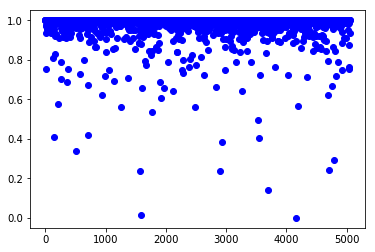

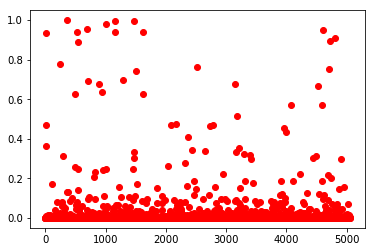

[41, 726, 1073, 1115, 1403, 2038, 2319, 2332, 2955, 3281, 9214, 9435, 9615]


In [135]:
#train map
#train_data = run_epoch(train_init_op, train=False)
predictions = train_data.pred
non_idx = np.where(train[:,0] == 0.)[0]
yes_idx = np.where(train[:,0] == 1.)[0]
print(len(predictions))
plt.plot([predictions[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([predictions[i] for i in non_idx], 'ro')
plt.show()
print ([x for x in non_idx if predictions[x] > 0.8])
#print (classification_report(train[:,0], predictions > 0.8))

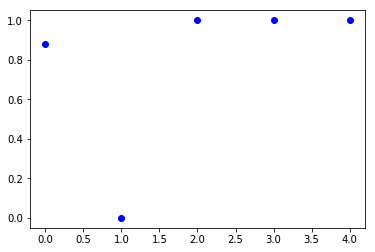

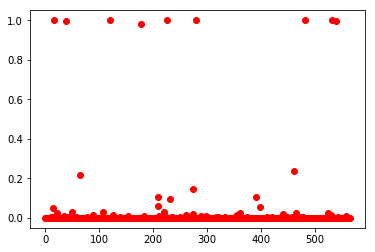

[21, 43, 124, 183, 230, 285, 487, 537, 544]


In [136]:
# Test map
#test_data = run_epoch(test_init_op, train=False)
predictions = test_data.pred
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
plt.plot([predictions[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([predictions[i] for i in non_idx], 'ro')
plt.show()
print ([x for x in non_idx if predictions[x] > 0.8])
#print (classification_report(y_test, predictions > 0.8))

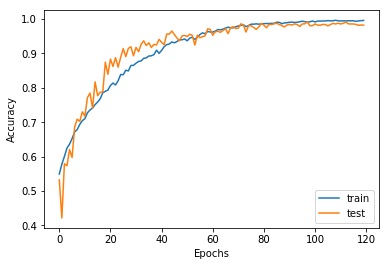

In [134]:
plt.plot([epoch_datas[x]['train_data'].acc for x in range(len(epoch_datas))])
plt.plot([epoch_datas[x]['test_data'].acc for x in range(len(epoch_datas))])
plt.legend(['train', 'test'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

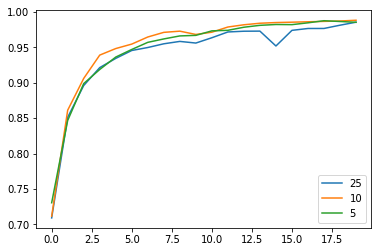

In [33]:
labels = []
for data, label in train_plots:
    if label is '5' or label is '10' or label is '25':
        plt.plot(data)
        labels.append(label)
    
plt.legend(labels, loc='lower right')
plt.show()


[0]


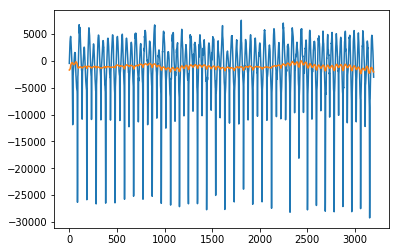

In [22]:
index = 2691
print (y_train[index])
plt.plot(x_train[index])
plt.show()